# 02 – Feature Engineering for Sentinel

This notebook transforms the cleaned TradyFlow options dataset into a modeling-ready feature matrix for Sentinel (our premarket forecasting system).

The goal of this stage is simple:

> **Convert raw options flow into numerical signals the model can understand.**

This includes:

- Loading the cleaned dataset

- Applying the standardized feature engineering pipeline

- Exploring the new feature distributions

- Removing extreme outliers

- Saving the modeling dataset to `data/processed/`

Feature engineering is where predictive power is created.
Modeling is just math — **features determine the ceiling**.

# 1. Imports + Loader Test

In this step, we:

- Add the project root to `sys.path`

- Import the data loader and feature builder

- Initialize plotting libraries

The goal is to ensure that Sentinel’s `src/` modules behave like a real ML package and load cleanly.

This confirms that the pipeline can run the same way in a notebook, a script, or an API.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import importlib
from src.features import feature_builder
importlib.reload(feature_builder)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.load_tradyflow import load_tradyflow_processed
from src.features.feature_builder import build_basic_features

plt.style.use("default")
sns.set_theme(style="whitegrid")

[config] Warning: POLYGON_API_KEY is not set – live calls will fail.


# 2. Load Dataset

We load the cleaned TradyFlow dataset saved from Notebook 01.

This dataset includes:

- Time of the sweep

- Underlying ticker

- Strike, expiration, bid/ask

- Volume, premiums, open-interest

- Direction (Call/Put)

- In-the-money status

No feature engineering yet — this is still “real-world data” as traders see it.

The objective here is simply to verify:

- The loader works

- The file exists

- The data looks correct

Once verified, we move to building modeling features.

In [2]:
df = load_tradyflow_processed()
df.head()

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,OI,Diff(%),ITM
0,6/17/2022 15:07,ISEE,Call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0
1,6/17/2022 15:05,CVNA,Call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,130,155.05,0
2,6/17/2022 14:51,PTLO,Put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,0,1.39,0
3,6/17/2022 14:39,TWLO,Call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,436,2.48,0
4,6/17/2022 13:56,ATUS,Put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0


# 3. Apply Feature Builder

This is the core of Sentinel’s ML pipeline.

The `build_basic_features()` function:

- Parses timestamps

- Converts volume/premium/OI strings like `"183.60K"` → float

- Computes **moneyness**

- Computes **bid-ask spread %**

- Computes **flow intensity** (premium-weighted volume)

- Applies log-transforms to reduce skew

- Computes **days to expiration (DTE)**

- Encodes call/put into numeric flags

These engineered features represent:

- Liquidity

- Sentiment

- Order size

- Strike positioning

- Time decay pressure

This standardized feature block is used for BOTH training and future inference, giving Sentinel consistency across environments.

In [3]:
df_feat = build_basic_features(df)
df_feat.head()
df_feat.columns

Index(['Time', 'Sym', 'C/P', 'Exp', 'Strike', 'Spot', 'BidAsk', 'Orders',
       'Vol', 'Prems', 'OI', 'Diff(%)', 'ITM', 'Time_dt', 'Exp_dt',
       'moneyness', 'spread_pct', 'flow_intensity', 'log_vol', 'log_prems',
       'dte', 'is_call', 'is_put'],
      dtype='object')

# 4. Quick Feature Health Check

Before modeling, we verify:

- No missing values

- Reasonable ranges

- No extreme or corrupted values

- Datetime parsing succeeded

- Derived features behave as expected

We review statistics such as:

- Distribution of volume and premiums (highly skewed, so log-transform is useful)

- Moneyness values clustering around ±0.2

- Spread percentages typically under 10%

- DTE ranging widely across contracts

A clean descriptive table confirms the feature pipeline performed correctly.

In [4]:
df_feat.describe().T

,count,mean,min,25%,50%,75%,max,std
Strike,7827.0,151.178342,1.5,30.0,60.0,145.0,3950.0,358.668235
Spot,7827.0,148.59549,1.23,28.27,58.95,145.16,3755.25,353.566766
BidAsk,7827.0,4.220649,0.11,1.65,3.1,5.12,194.35,5.207856
Orders,7827.0,7.109493,5.0,5.0,5.0,7.0,124.0,5.312003
Vol,7827.0,2740.656573,250.0,708.0,1310.0,2810.0,131530.0,4931.768058
Prems,7827.0,718967.223713,125250.0,238865.0,367630.0,674975.0,62350000.0,1484765.183886
OI,7827.0,8343.801712,0.0,653.0,2760.0,8630.0,353080.0,16733.487775
Diff(%),7827.0,11.477625,0.02,2.11,5.6,12.715,277.64,19.367772
ITM,7827.0,0.679826,0.0,0.0,1.0,1.0,1.0,0.466573
Time_dt,7827,2021-10-25 05:04:42.736680704,2021-06-07 09:48:00,2021-08-03 14:31:00,2021-10-05 14:38:00,2021-12-27 11:02:00,2022-06-17 15:07:00,NaN


# 5. Visualize Important Features

Visualization helps confirm the intuition behind each feature:

**log_vol**

- Shows size of option sweeps on a normalized scale

- Reduces the impact of extremely large trades

**moneyness**

- Measures how far ITM/OTM a contract is

- Helps the model learn risk-reward behavior

**spread_pct**

- Indicates liquidity

- High spreads → low participation + less reliability

Plots confirm distributions look normal and modeling-friendly.

<Axes: xlabel='log_vol', ylabel='Count'>

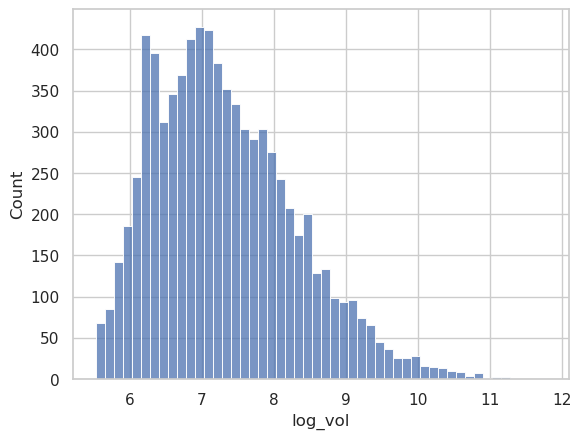

In [5]:
# Volume Feature 

sns.histplot(df_feat["log_vol"], bins=50)

<Axes: xlabel='moneyness', ylabel='Count'>

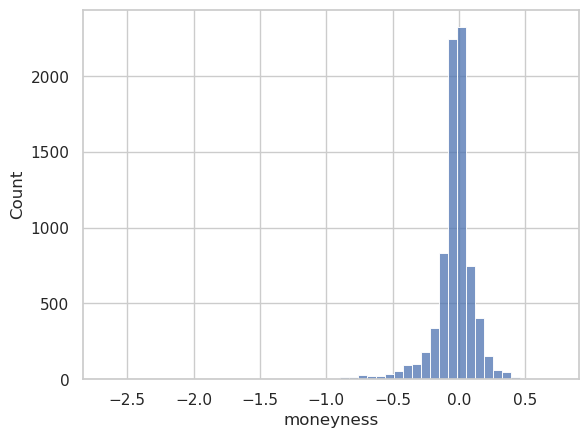

In [6]:
# Moneyness

sns.histplot(df_feat["moneyness"], bins=50)

<Axes: xlabel='spread_pct', ylabel='Count'>

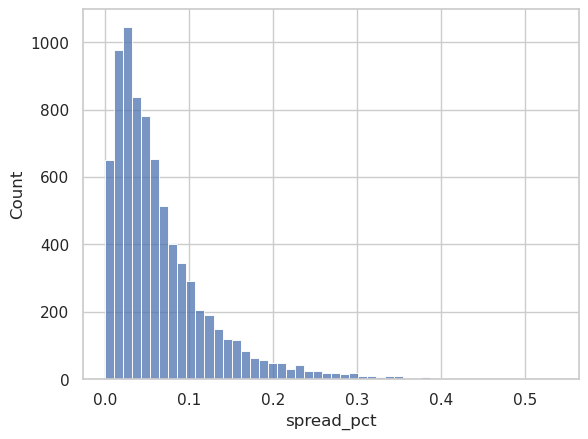

In [7]:
# Bid-Ask Spread

sns.histplot(df_feat["spread_pct"], bins=50)

# 6. Outlier Removal Rules

We apply simple, conservative filtering rules:

- Remove extremely high bid-ask spreads

- Keep moneyness within a reasonable band

- Cap extreme trade volumes at the 99.9th percentile

These filters:

- Reduce noise

- Prevent models from over-fitting on rare anomalies

- Improve generalization

Outlier removal is not about “hiding data” —
it ensures the model focuses on **behavior that repeats**, not one-off freak trades.

In [8]:
df_feat = df_feat[(df_feat["spread_pct"] < 1.0)]
df_feat = df_feat[(df_feat["moneyness"].between(-2, 2))]
df_feat = df_feat[df_feat["Vol"] < df_feat["Vol"].quantile(0.999)]

# 7. Save Modeling Dataset

Finally, we save the modeling-ready dataset to:

```
data/processed/tradyflow_modeling.parquet
```

This file will be the input for:

- Notebook 03 (Model Training)

- Azure ML pipelines

- Future inference jobs

- Backtesting tools

Standardizing the dataset at this stage ensures reproducibility and consistent experimentation.

In [9]:
out_path = "../data/processed/tradyflow_modeling.parquet"
df_feat.to_parquet(out_path)
out_path

'../data/processed/tradyflow_modeling.parquet'